# 2D Convolution and Convoltional Layers

In this demo, you will learn to:
* Compute 2D convolutions on images using `scipy`.
* Visualize the outputs of convolutions
* Create a convolutional layer in Keras
* Mathematically describe the weights with multiple input and output channels

## Loading and Displaying Images

We first import several packages.  Two important packages we will use are: 
* `scipy.signal`: sub-package which has useful routines for 2D convolutions; and
* `skimage.data`: sub-package for getting some basic images.

In [1]:
import numpy as np
import scipy.signal
import skimage.data
import matplotlib.pyplot as plt
%matplotlib inline

We next create a function to display images that we will use throughout the demo.  The function does both gray-scale and color images.

In [2]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

The `skimage.data` package has several commonly used images in image processing.  We begin by loading a widely-used "cameraman" image.  

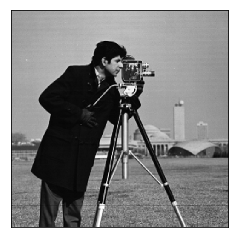

In [3]:
im = skimage.data.camera()
disp_image(im)

We print the image shape

In [4]:
print("The image shape is: "+str(im.shape))

The image shape is: (512, 512)


We can also load images from files using the `skimage.io.imread` function.  This function can handle most common image formats including, for example, JPG.

The image shape is: (368, 487, 3)


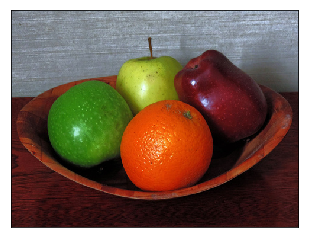

In [5]:
fname = 'still_life.jpg'
im_color = skimage.io.imread(fname)
disp_image(im_color)
print("The image shape is: "+str(im_color.shape))

## Performing 2D Convolutions

To illustrate the 2D convolutions, we first create two common filters.  These filters are the [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator), `Gx` and `Gy`.  The filter `Gx` filter will have a large response when there is a large positive change in the x-direction.  Similarly, `Gy` will have a large response for a large change in the image in the y-direction.  The filters are thus often gradient filters.  In any part of the image that is flat, the output is zero.

In [6]:
Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])  # Gradient operator in the x-direction
Gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])  # Gradient operator in the y-direction

To perform the convolution, we must first *flip* the filters in the x and y-directions.

In [7]:
Gxflip = np.fliplr(np.flipud(Gx))
Gyflip = np.fliplr(np.flipud(Gy))

Then, we can apply the `convolve2d` routine for each filter.  The output `mode = 'valid'` selects the output pixels only where no zero padding is required.  We see that the output is large on the horizontal and vertical boundaries.

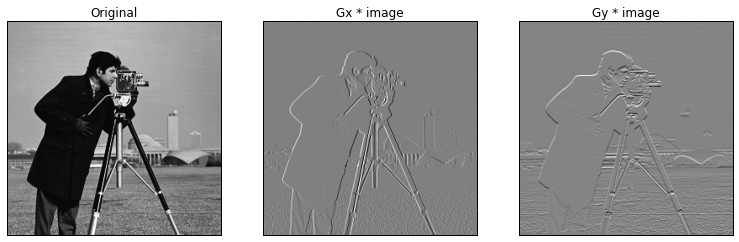

In [8]:
# Perform the convolutions
imx = scipy.signal.convolve2d(im, Gxflip, mode='valid')
imy = scipy.signal.convolve2d(im, Gyflip, mode='valid')

# Plot the original image and the two outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(imx)
plt.title('Gx * image')
plt.subplot(1,3,3)
disp_image(imy)
plt.title('Gy * image')

Note that the output shape is slightly reduced due to using the `mode='valid'` option.

In [9]:
print("Input shape = " + str(im.shape))
print("Output shape = " + str(imx.shape))

Input shape = (512, 512)
Output shape = (510, 510)


While the filters above are sensitive to edges, we can also create filters that are senstive to the average value in some area.  For example, the uniform kernel `G_unif` below averages the values in some region of `(kx,ky)` pixels.  The Gaussian kernel also performs an averaging, but weights the pixels at the center of the kernel more.

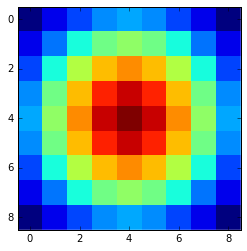

In [11]:
def gauss_kernel(nx,ny,sig):
    """
    Creates a Gaussian kernel of size (nx,ny) with std deviation sig
    """
    dxsq = (np.arange(nx)-(nx-1)/2)**2
    dysq = (np.arange(ny)-(ny-1)/2)**2
    dsq = dxsq[:,None] + dysq[None,:]
    G = np.exp(-0.5*dsq/(sig**2))
    G = G / np.sum(G)
    return G

# Create a uniform kernel
kx = 9
ky = 9
sig = 3
G_unif = np.ones((kx,ky))/(kx*ky)

# Create a Gaussian kernel
G_gauss = gauss_kernel(kx,ky,sig)
plt.imshow(G_gauss,interpolation='None')

Convolving with these kernels creates blurry version of the image.

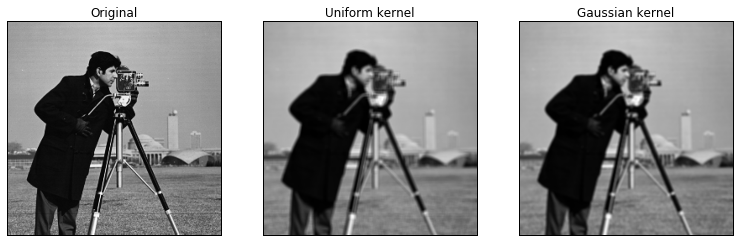

In [12]:
# Peform the convolution
Gunif_flip = np.fliplr(np.flipud(G_unif))
Ggauss_flip = np.fliplr(np.flipud(G_gauss))
im_unif = scipy.signal.convolve2d(im, Gunif_flip, mode='valid')
im_gauss = scipy.signal.convolve2d(im, Ggauss_flip, mode='valid')

# Plot the original image and the two outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(im_unif)
plt.title('Uniform kernel')
plt.subplot(1,3,3)
disp_image(im_gauss)
plt.title('Gaussian kernel')

Note that since we have selected `valid` in the

## Implementing a Convolutional Layer Keras

We now show how to implement a convolutional layer in Keras.  Typically, in Keras, images are represented as 4-th order tensors with dimensions `(batch_size,height,width,nchannels)`, where `batch_size` is the number of images in a batch, `(height,width)` is the images size per channel and `nchannels` is the number of image channels.  For BW images, there is only one channel. We first reshape the image to this format.

In [13]:
nrow, ncol = im.shape 
nimage = 1         # number of images in batch
nchan_in = 1       # number of input channels.  1 since it is BW
input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
batch_shape = (nimage,nrow,ncol,nchan_in)  # shape of image batch
x = im.reshape(batch_shape)

Next, we import the appropriate Keras packages.  

In [14]:
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D
import keras.backend as K

Using TensorFlow backend.


We now create a simple network with one convolutional layer and two output channels.

In [15]:
K.clear_session()
model = Sequential()
kernel_size = Gx.shape
nchan_out = 2
model.add(Conv2D(input_shape=input_shape,filters=nchan_out,
                 kernel_size=kernel_size,name='conv2d'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 2)       20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


The weights are represented as a `(3,3,1,2)` which correspond to `(krow,kcol,nchan_in,nchan_out)`.  Thus, for each input and output channel pair, there is one kernel of size `(krow,kcol)`. The bias has size `(nchan_out,)` corresponding to one bias value per output channel.

In [17]:
layer = model.get_layer('conv2d')
W, b = layer.get_weights()
print("W shape = " + str(W.shape))
print("b shape = " + str(b.shape))

W shape = (3, 3, 1, 2)
b shape = (2,)


We set the two filters using the gradients `Gx` and `Gy`.  Note that they do not need to be flipped.

In [18]:
W[:,:,0,0] = Gx
W[:,:,0,1] = Gy
b = np.zeros(nchan_out)
layer.set_weights((W,b))

We can now run the image through the convolutional layer and display the outputs.  We get the same outputs as we did earlier.

In [19]:
x = im.reshape(batch_shape)
y = model.predict(x)

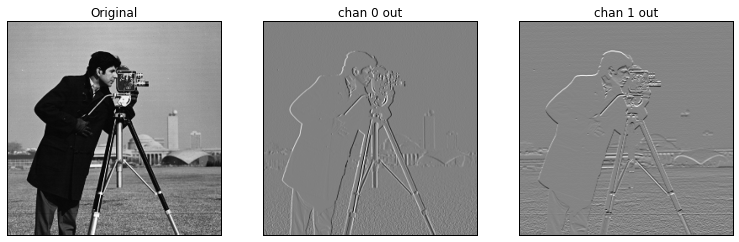

In [20]:
# Plot the original image and the two outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(y[0,:,:,0])
plt.title('chan 0 out')
plt.subplot(1,3,3)
disp_image(y[0,:,:,1])
plt.title('chan 1 out')


## Using Multiple Input and Output Channels

We now create a keras model with a single convolutional layer to process the color image.  We first get the dimensions of the color image.

Image shape is (368, 487, 3)


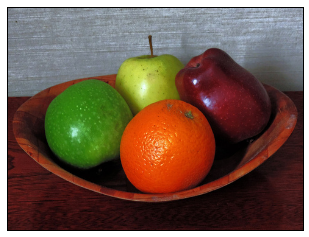

In [21]:
disp_image(im_color)
nrow,ncol,nchan_in = im_color.shape
nimage = 1
input_shape = (nrow,ncol,nchan_in)
batch_shape = (nimage,nrow,ncol,nchan_in)
print("Image shape is "+str(im_color.shape))

# Reshape image to a batch
x = im_color.reshape(batch_shape)

We now create a network with a single convolutional layer with `nchan_out=4` output channels.

In [23]:
# Dimensions
nchan_out = 4
kernel_size = (9,9)

# Create network
K.clear_session()
model = Sequential()
model.add(Conv2D(input_shape=input_shape,filters=nchan_out,
                 kernel_size=kernel_size,name='conv2d'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 479, 4)       976       
Total params: 976
Trainable params: 976
Non-trainable params: 0
_________________________________________________________________


As before, the weight matrix is of size `(krow,kcol,nchan_in,nchan_out)` so that there is one kernel of size `(krow,kcol)` per input-output channel pair.

In [25]:
layer = model.get_layer('conv2d')
W, b = layer.get_weights()
print(W.shape)
print(b.shape)

(9, 9, 3, 4)
(4,)


To illustrate the 2D convolutions, we create kernels of the form:

    W[a,b,i,j] = G[a,b]*color_wt[j,i]
    
where `color_wt[i,j]` represents the weighting of color channel `i` for output channel `j` and `G[:,:]` is a uniform kernel over space.

In [26]:
# Color weights
color_wt = np.array([
    [1,    -0.5, -0.5],   # Sensitive to red
    [-0.5,    1, -0.5],   # Sensitive to green
    [-0.5, -0.5,    1],   # Sensitive to blue
    [ 0.5,   -1,  0.5],   # Sensitive to red-blue mix
])

# Uniform kernel
krow, kcol = kernel_size
G = gauss_kernel(krow,kcol,sig=2)

b = np.zeros(b.shape)
for i in range(nchan_in):
    for j in range(nchan_out):
        W[:,:,i,j] = G*color_wt[j,i]
layer.set_weights((W,b))

We plot the filters.  The filter for each output channel is itself a small RGB image and indicates which local feature it is sensitive to.

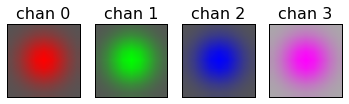

In [27]:
for i in range(nchan_out):
    plt.subplot(1,nchan_out,i+1)
    disp_image(W[:,:,:,i])
    title_str = 'chan %d' % i
    plt.title(title_str,fontsize=16)

We now run the image through the network.  We see that the output feature maps clearly indicate the different colors.

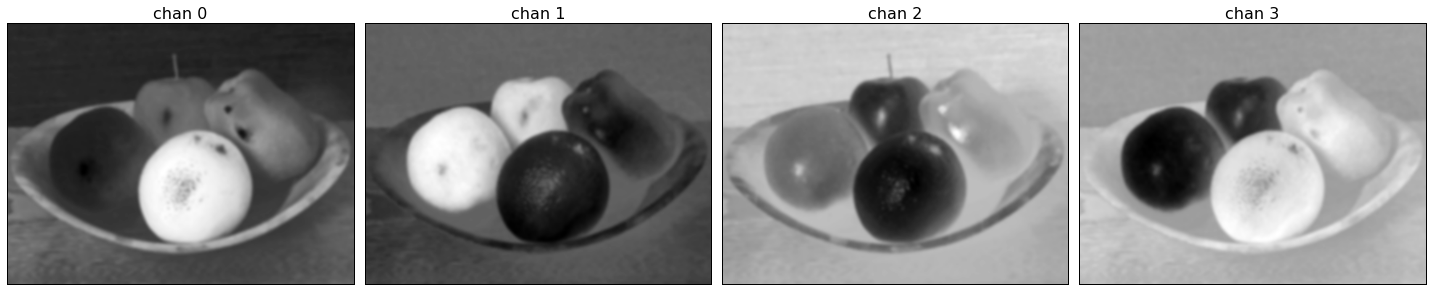

In [28]:
y = model.predict(x)
plt.figure(figsize=(20,20))
for i in range(nchan_out):
    plt.subplot(2,nchan_out,i+1)
    disp_image(y[0,:,:,i])
    title_str = 'chan %d' % i
    plt.title(title_str,fontsize=16)
plt.tight_layout()